In [1]:
# all necessary imports for project
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [3]:
'''LOADING DATA FROM FILES'''

import pandas as pd
import os

# Load label file
label_df = pd.read_excel('../Data/wax/data labels anna - simple.xlsx')
# clean up column names
label_df.columns = ['code', 'month', 'ID', 'optimality', 'abnormal', 'AIMS']
print(label_df.head())

# Cleanup data, remove rows where AIMS score is 999
AIMS_cleaned_label_df = label_df[label_df.AIMS != 999]

   code  month   ID  optimality  abnormal  AIMS
0  1023      0  180           9       1.0     1
1  1023      1  195          14       1.0   999
2  1023      2  197          26       1.0     1
3  1023      3  206          11       1.0     2
4  1023      4  208          13       1.0     1


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import sys

def load_sensor_data(trial_folder, sensor):
    df = pd.read_csv(trial_folder + "/" + sensor + ".csv")
    df = df[(df.T != 0).any()]
    return df

'''def truncate_df(df, min_rows):
    return df[:min_rows]'''

def combine_dfs(dfs):
    return pd.concat(dfs, axis=1)

def process_df(df, min_rows):
    # Drop rows where all entries are zero
    df = df[(df.T != 0).any()]
    # Truncate dataframe to min_rows
    df = df[:min_rows]
    return df

def rename_columns(df):
    df.columns = ['Time', 'AccXRA', 'AccYRA', 'AccZRA', 'GyrXRA', 'GyrYRA', 'GyrZRA', 'MagXRA', 'MagYRA', 'MagZRA',
                  'AccXLA', 'AccYLA', 'AccZLA', 'GyrXLA', 'GyrYLA', 'GyrZLA', 'MagXLA', 'MagYLA', 'MagZLA',
                  'AccXRW', 'AccYRW', 'AccZRW', 'GyrXRW', 'GyrYRW', 'GyrZRW', 'MagXRW', 'MagYRW', 'MagZRW',
                  'AccXLW', 'AccYLW', 'AccZLW', 'GyrXLW', 'GyrYLW', 'GyrZLW', 'MagXLW', 'MagYLW', 'MagZLW']
    return df

def renames_columns_sum(df):
    df.columns = ['Time', 'AccXRA', 'AccYRA', 'AccZRA', 'AccSumRA', 'GyrXRA', 'GyrYRA', 'GyrZRA', 'MagXRA', 'MagYRA', 'MagZRA',
                  'AccXLA', 'AccYLA', 'AccZLA', 'AccSumLA', 'GyrXLA', 'GyrYLA', 'GyrZLA', 'MagXLA', 'MagYLA', 'MagZLA',
                  'AccXRW', 'AccYRW', 'AccZRW', 'AccSumRW', 'GyrXRW', 'GyrYRW', 'GyrZRW', 'MagXRW', 'MagYRW', 'MagZRW',
                  'AccXLW', 'AccYLW', 'AccZLW', 'AccSumLW', 'GyrXLW', 'GyrYLW', 'GyrZLW', 'MagXLW', 'MagYLW', 'MagZLW']
    return df

def calculate_acceleration_sums(df):
    df['AccSumRA'] = np.sqrt(df['AccXRA']**2 + df['AccYRA']**2 + df['AccZRA']**2)
    df['AccSumLA'] = np.sqrt(df['AccXLA']**2 + df['AccYLA']**2 + df['AccZLA']**2)
    df['AccSumRW'] = np.sqrt(df['AccXRW']**2 + df['AccYRW']**2 + df['AccZRW']**2)
    df['AccSumLW'] = np.sqrt(df['AccXLW']**2 + df['AccYLW']**2 + df['AccZLW']**2)
    return df

def calculate_rolling_mean(df, window_size):
    df['AccSumSumR_Rolling10000'] = df['AccSumSumR'].rolling(window_size).mean()
    return df

def trim_df(df, start_index, end_index):
    return df.iloc[start_index:end_index-10000]

def drop_columns(df, columns):
    df.drop(columns=columns, inplace=True)
    return df

def calculate_peak_indices(first_half, second_half, column_name):
    start_peak_index = first_half[column_name].idxmax() + 10000
    end_peak_index = second_half[column_name].idxmax() - 10000
    return start_peak_index, end_peak_index

def process_trial(index, row, label_df):

    if index%10 == 0:
        print("processing instance", index)

    trial_id = row["ID"]
    infant_id = row["code"]

    if trial_id < 10:
        addedZero = '00'
    elif row['ID'] < 100:
        addedZero = '0'
    else:
        addedZero = ''

    trial_folder = '../Data/wax/p' + addedZero + str(trial_id)

    ra_df = load_sensor_data(trial_folder, "RA")
    la_df = load_sensor_data(trial_folder, "LA")
    rw_df = load_sensor_data(trial_folder, "RW")
    lw_df = load_sensor_data(trial_folder, "LW")

    # Get the minimum number of rows across all dataframes
    min_rows = min(ra_df.shape[0], la_df.shape[0], rw_df.shape[0], lw_df.shape[0])  

    #Process each dataframe
    ra_df = process_df(ra_df, min_rows)
    la_df = process_df(la_df, min_rows)
    rw_df = process_df(rw_df, min_rows)
    lw_df = process_df(lw_df, min_rows)

    # Remove first column from la, rw, lw dfs using indexing
    la_df = la_df.iloc[:, 1:]
    rw_df = rw_df.iloc[:, 1:]
    lw_df = lw_df.iloc[:, 1:]

    combined_df = combine_dfs([ra_df, la_df, rw_df, lw_df])
    # find number of columns in combined_df
    num_cols = combined_df.shape[1]

    # If number of columns is 37, acc, gyr and mag data is present.
    # If number of columns is 13, only acc data is present.
    if num_cols == 37:
        combined_df = rename_columns(combined_df)
        combined_df = calculate_acceleration_sums(combined_df)
        allSensors = True
    else:
        combined_df.columns = ['Time', 'AccXRA', 'AccYRA', 'AccZRA', 'AccXLA', 'AccYLA', 'AccZLA', 'AccXRW', 'AccYRW', 'AccZRW', 'AccXLW', 'AccYLW', 'AccZLW']
        combined_df = calculate_acceleration_sums(combined_df)
        allSensors = False


    #combined_df = rename_columns(combined_df)
    #combined_df = calculate_acceleration_sums(combined_df)

    # Split df in half
    first_half = combined_df.iloc[0:combined_df.shape[0]//2]
    second_half = combined_df.iloc[combined_df.shape[0]//2:combined_df.shape[0]]
   
    ra_start_peak_index, ra_end_peak_index = calculate_peak_indices(first_half, second_half, 'AccSumRA')
    la_start_peak_index, la_end_peak_index = calculate_peak_indices(first_half, second_half, 'AccSumLA')
    rw_start_peak_index, rw_end_peak_index = calculate_peak_indices(first_half, second_half, 'AccSumRW')
    lw_start_peak_index, lw_end_peak_index = calculate_peak_indices(first_half, second_half, 'AccSumLW')

    starts = [ra_start_peak_index, la_start_peak_index, rw_start_peak_index, lw_start_peak_index]
    ends = [ra_end_peak_index, la_end_peak_index, rw_end_peak_index, lw_end_peak_index]

    max_end = max(ends)
    max_index = ends.index(max_end)
    max_start = starts[max_index]
    difference = max_end - max_start

    ra_df_trimmed = trim_df(ra_df, ra_start_peak_index, ra_start_peak_index + difference)
    la_df_trimmed = trim_df(la_df, la_start_peak_index, la_start_peak_index + difference)
    rw_df_trimmed = trim_df(rw_df, rw_start_peak_index, rw_start_peak_index + difference)
    lw_df_trimmed = trim_df(lw_df, lw_start_peak_index, lw_start_peak_index + difference) 
    
    # Reset the index of each df
    ra_df_trimmed = ra_df_trimmed.reset_index(drop=True)
    la_df_trimmed = la_df_trimmed.reset_index(drop=True)
    rw_df_trimmed = rw_df_trimmed.reset_index(drop=True)
    lw_df_trimmed = lw_df_trimmed.reset_index(drop=True)


    trimmed_df = combine_dfs([ra_df_trimmed, la_df_trimmed, rw_df_trimmed, lw_df_trimmed])
    num_cols = trimmed_df.shape[1]

    if num_cols == 37:
        trimmed_df = rename_columns(trimmed_df)
        trimmed_df = calculate_acceleration_sums(trimmed_df)
    else:
        trimmed_df.columns = ['Time', 'AccXRA', 'AccYRA', 'AccZRA', 'AccXLA', 'AccYLA', 'AccZLA', 'AccXRW', 'AccYRW', 'AccZRW', 'AccXLW', 'AccYLW', 'AccZLW']
        trimmed_df = calculate_acceleration_sums(trimmed_df)

    # Plot trimmed_df for every 10 instances (sanity check)
    if index % 50 == 0:
        trimmed_df.plot(x='Time', y=['AccSumRA', 'AccSumLA', 'AccSumRW', 'AccSumLW'], title='Sum of Accelerometer Values for each limb (Data trimmed)')    


    # If trimmed_df is empty, raise an exception. Prevents empty dataframes from being added to the list
    if trimmed_df.empty:
        raise Exception("Empty dataframe")

    return trimmed_df, row['month'], row['code'], row['abnormal'], row['AIMS'], row['optimality'], allSensors

processing instance 0
File not found for instance 0
File not found for instance 2
File not found for instance 3
File not found for instance 4
File not found for instance 5
File not found for instance 6
processing instance 10
File not found for instance 11
Error processing instance 14
Error Empty dataframe
Error on line 11
Error on line 161
File not found for instance 17
File not found for instance 18
processing instance 20
File not found for instance 22
File not found for instance 23
File not found for instance 29
processing instance 30
File not found for instance 39
processing instance 40
processing instance 50
Error processing instance 58
Error Empty dataframe
Error on line 11
Error on line 161
processing instance 60
processing instance 70
processing instance 80
File not found for instance 82
processing instance 90
File not found for instance 94
processing instance 100
processing instance 110
File not found for instance 116
File not found for instance 117
processing instance 120
File

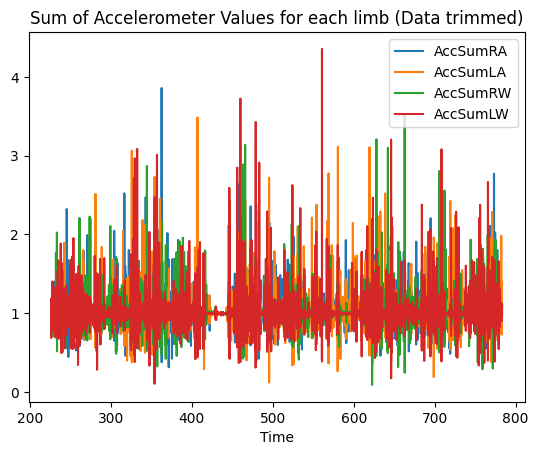

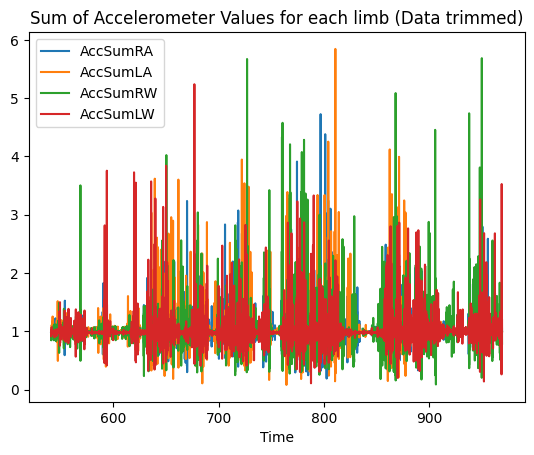

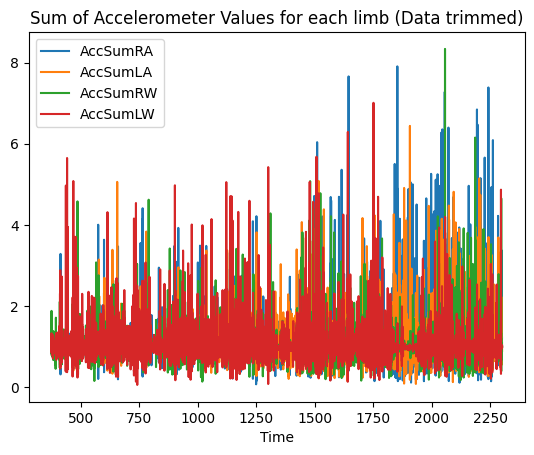

In [5]:
# Create 1 big dataframe with all the data
'''allData = {'Measurements': [], 'Month': [], 'Code': [], 'Abnormal': [], 'AIMS': [], 'Optimality': []}'''
accelData = {'Measurements': [], 'Month': [], 'Code': [], 'Abnormal': [], 'AIMS': [], 'Optimality': []}

# Keep track of rows that raise exceptions
error_rows = []

def save_trials():
    for index, row in label_df.iterrows():
        try:
            measurements, month, code, abnormal, aims, optimality, allSensors = process_trial(index, row, label_df)

            if allSensors:
                '''

                # Add all data collected to allData
                allData['Measurements'].append(measurements)
                allData['Month'].append(month)
                allData['Code'].append(code)
                allData['Abnormal'].append(abnormal)
                allData['AIMS'].append(aims)
                allData['Optimality'].append(optimality)
                '''

                # Add only accelerometer data to accelData
                just_accel = measurements.copy()
                
                cols = ['MagXRA', 'MagYRA', 'MagZRA', 'MagXLA', 'MagYLA', 'MagZLA', 'MagXRW', 'MagYRW', 'MagZRW', 'MagXLW', 'MagYLW', 'MagZLW',
                'GyrXRA', 'GyrYRA', 'GyrZRA', 'GyrXLA', 'GyrYLA', 'GyrZLA', 'GyrXRW', 'GyrYRW', 'GyrZRW', 'GyrXLW', 'GyrYLW', 'GyrZLW']

                just_accel.drop(columns=cols, inplace=True)
    

                accelData['Measurements'].append(just_accel)
                accelData['Month'].append(month)
                accelData['Code'].append(code)
                accelData['Abnormal'].append(abnormal)
                accelData['AIMS'].append(aims)
                accelData['Optimality'].append(optimality)

            else:
                
                # if only accelerometer data was collected, just add it to accelData
                accelData['Measurements'].append(measurements)
                accelData['Month'].append(month)
                accelData['Code'].append(code)
                accelData['Abnormal'].append(abnormal)
                accelData['AIMS'].append(aims)
                accelData['Optimality'].append(optimality)

        except FileNotFoundError:
            print("File not found for instance", index)
            error_rows.append((index, row))

        except Exception as e:
            print("Error processing instance", index)
            print("Error", e) 
            # print line number of error
            print("Error on line {}".format(sys.exc_info()[-1].tb_lineno))
            # print line further back in the traceback
            print("Error on line {}".format(sys.exc_info()[-1].tb_next.tb_lineno))
            error_rows.append((index, row)) 

save_trials()



In [6]:
# save accelData to a pickle should kernel have to restart
import pickle
with open('Pickles/accelData.pickle', 'wb') as handle:
    pickle.dump(accelData, handle)

# Save to original file in case any issues happen when resaving
with open('Pickles/accelDataOriginal.pickle', 'wb') as handle:
    pickle.dump(accelData, handle)

In [7]:
# open accelData pickle
import pickle
with open('Pickles/accelData.pickle', 'rb') as handle:
    accelData = pickle.load(handle)

In [8]:
K = 14

# Split some of the longer trials in half
numRowsAccel = [df.shape[0] for df in accelData['Measurements']]
sortedIndices = np.argsort(numRowsAccel)

# Get the indices of the top k dataframes
topKIndices = sortedIndices[-K:]

# Get the top k dataframes
topKDataframes = [accelData['Measurements'][i] for i in topKIndices]

# Get the top k corresponding months, IDs, labels
topKMonths = [accelData['Month'][i] for i in topKIndices]
topKCodes = [accelData['Code'][i] for i in topKIndices]
topKAbnormal = [accelData['Abnormal'][i] for i in topKIndices]
topKAIMS = [accelData['AIMS'][i] for i in topKIndices]
topKOptimality = [accelData['Optimality'][i] for i in topKIndices]

# Remove the dataframes from accelData
for i in sorted(topKIndices, reverse=True):
    del accelData['Measurements'][i]
    del accelData['Month'][i]
    del accelData['Code'][i]
    del accelData['Abnormal'][i]
    del accelData['AIMS'][i]
    del accelData['Optimality'][i]

# Split the top k dataframes into two and reinsert into structure
for i in range(len(topKDataframes)):
    df = topKDataframes[i]
    month = topKMonths[i]
    code = topKCodes[i]
    abnormal = topKAbnormal[i]
    aims = topKAIMS[i]
    optimality = topKOptimality[i]
    
    first_half = df.iloc[0:df.shape[0]//2]
    second_half = df.iloc[df.shape[0]//2:df.shape[0]]
    
    # Append the first and second halves to accelData
    accelData['Measurements'].append(first_half)
    accelData['Measurements'].append(second_half)
    
    # Append the corresponding values for month, code, abnormal, aims, and optimality
    accelData['Month'].extend([month, month])
    accelData['Code'].extend([code, code])
    accelData['Abnormal'].extend([abnormal, abnormal])
    accelData['AIMS'].extend([aims, aims])
    accelData['Optimality'].extend([optimality, optimality])
    
# Memory management
del numRowsAccel
del topKIndices
del sortedIndices
del topKDataframes
del topKMonths
del topKCodes
del topKAbnormal
del topKAIMS
del topKOptimality
del first_half
del second_half
del df
del month
del code
del abnormal
del aims
del optimality

In [9]:
# Create another key-value pair in the accelData dictionary with the measurement data normalised
accelData['Normalised'] = []
for i in range(len(accelData['Measurements'])):
    df = accelData['Measurements'][i]
    normalised = (df - df.mean()) / df.std()
    accelData['Normalised'].append(normalised)

# Memory management
del normalised
del df

In [10]:
# Add padding to the dataframes in accelData['Measurements'] and accelData['Normalised']

# Get the maximum number of rows in the dataframes
maxRows = max([df.shape[0] for df in accelData['Measurements']])
# Get the number of columns in the dataframes
numCols = accelData['Measurements'][0].shape[1]

# Add padding to the dataframes in accelData['Measurements']
for i in range(len(accelData['Measurements'])):
    df = accelData['Measurements'][i]
    padding = pd.DataFrame(np.zeros((maxRows - df.shape[0], numCols)), columns=df.columns)
    df = df.append(padding, ignore_index=True)
    accelData['Measurements'][i] = df

# Add padding to the dataframes in accelData['Normalised']
for i in range(len(accelData['Normalised'])):
    df = accelData['Normalised'][i]
    padding = pd.DataFrame(np.zeros((maxRows - df.shape[0], numCols)), columns=df.columns)
    df = df.append(padding, ignore_index=True)
    accelData['Normalised'][i] = df

# Memory management
del maxRows
del numCols
del padding
del df

In [11]:
# Create another key-value pair in the accelData dictionary with the measurement data segmented
# Data should be segmented into windows of 100 samples, non-overlapping
def segment_data(data, window_size):
    segments = []
    for i in range(0, len(data) - window_size, window_size):
        segment = data[i:i+window_size]
        segments.append(segment)
    return segments


# Segment the normalised data
window_size = 100
accelData['Segmented Normalised'] = []
def segment_normalised_data():
    for i in range(len(accelData['Normalised'])):
        df = accelData['Normalised'][i]
        segmented = segment_data(df, window_size)
        accelData['Segmented Normalised'].append(segmented)
    return
segment_normalised_data()

# Do the same for not normalised data
accelData['Segmented'] = []
def segment_not_normalised_data():
    for i in range(len(accelData['Measurements'])):
        df = accelData['Measurements'][i]
        segmented = segment_data(df, window_size)
        accelData['Segmented'].append(segmented)
    return
segment_not_normalised_data()

In [12]:
# Save accelData to a pickle
with open('Pickles/accelData.pickle', 'wb') as handle:
    pickle.dump(accelData, handle)

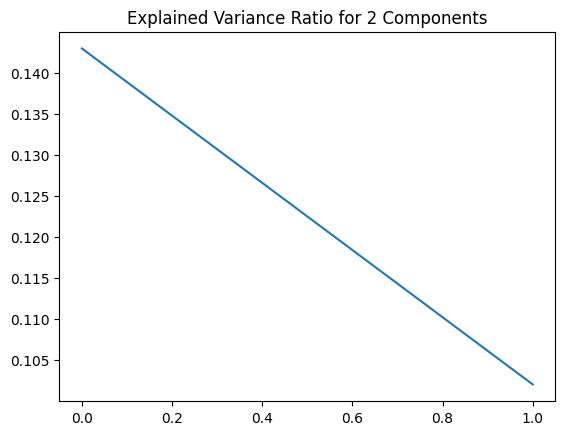

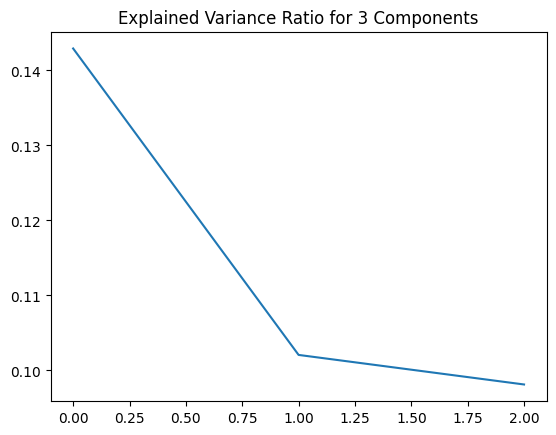

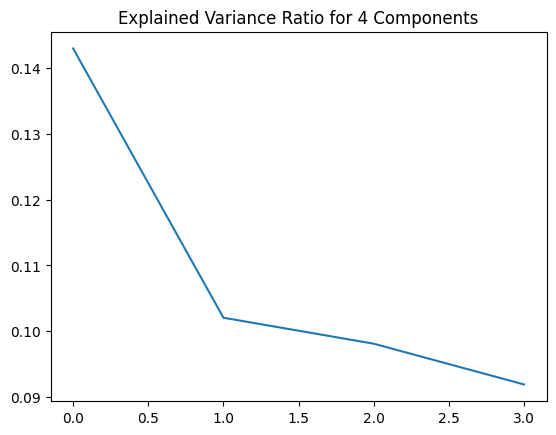

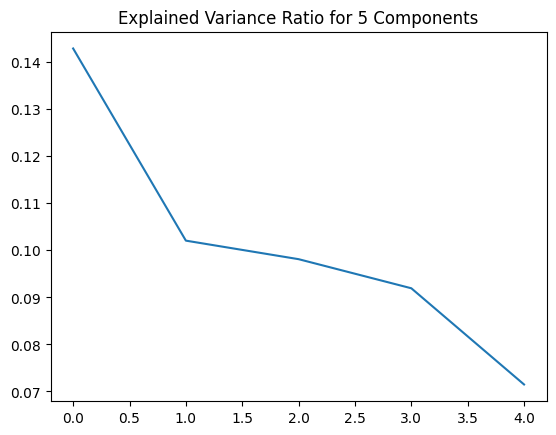

: 

In [ ]:
# PCA transform the following: normalised data, segmented normalised data, and segmented data
# Experiment with different numbers of components
from sklearn.decomposition import PCA

def pca_transform(data, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    transformed = pca.transform(data)

    plt.plot(pca.explained_variance_ratio_)
    plt.title('Explained Variance Ratio for ' + str(n_components) + ' Components')
    plt.show()

    # Plot the transformed data
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(transformed[:,0], transformed[:,1], transformed[:,2])
    plt.title('PCA Transform for ' + str(n_components) + ' Components')
    plt.show()

    return

pca_transform(accelData['Normalised'][0], 2)
pca_transform(accelData['Normalised'][0], 3)
pca_transform(accelData['Normalised'][0], 4)
pca_transform(accelData['Normalised'][0], 5)